In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.vae_model import vae_model
from src.visualization import plot_latent_space_with_tsne, plot_loss_history, plot_voxel
from src.voxel_util import (
    gen_voxel_ball_data,
    gen_voxel_brick_data,
    random_voxel_ball,
    random_voxel_brick,
)
from tensorflow.keras.optimizers import Adam

2023-12-29 19:50:24.302570: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 19:50:24.547636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 19:50:24.547721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 19:50:24.579803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 19:50:24.642136: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 19:50:24.642953: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# sources
# https://github.com/IsaacGuan/3D-VAE/blob/master/train.py
# https://github.com/ffriese/voxel_vae/tree/master
# https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py

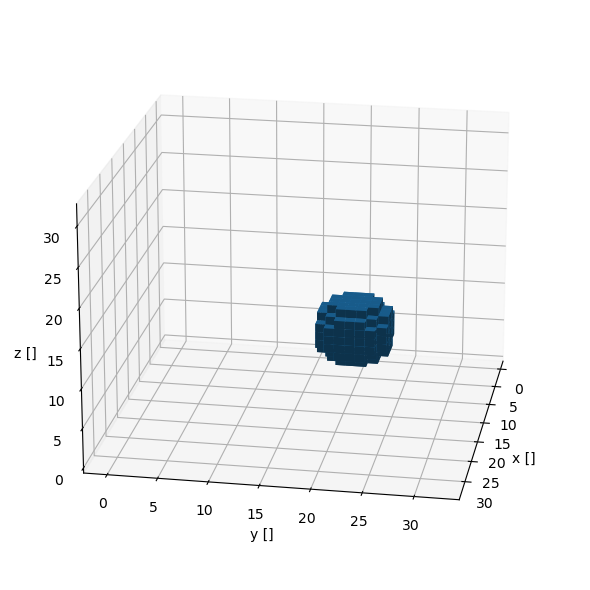

In [3]:
ball = True
if ball:
    d = 4
    plot_voxel(random_voxel_ball(d=d))
else:
    d_xyz = [5, 5, 5]
    plot_voxel(random_voxel_brick(d_xyz=d_xyz))

In [4]:
n_gammas = 500
if ball:
    gamma_train = gen_voxel_ball_data(num=n_gammas, d=d)
else:
    gamma_train = gen_voxel_brick_data(num=n_gammas, d_xyz=d_xyz)

print(gamma_train.shape)

(500, 32, 32, 32, 1)


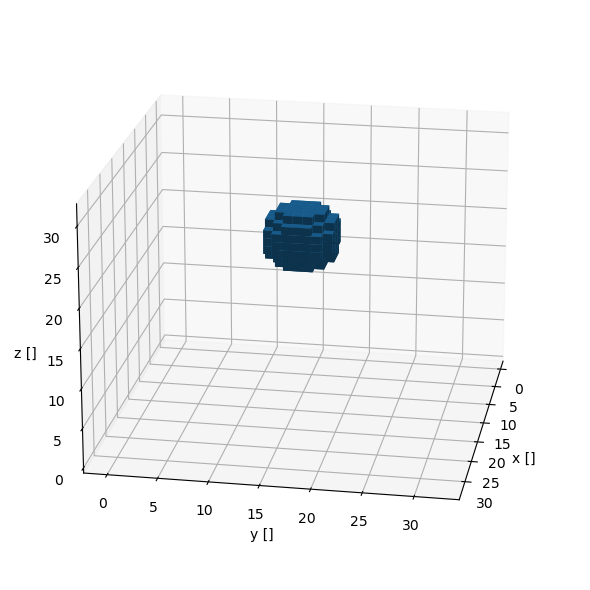

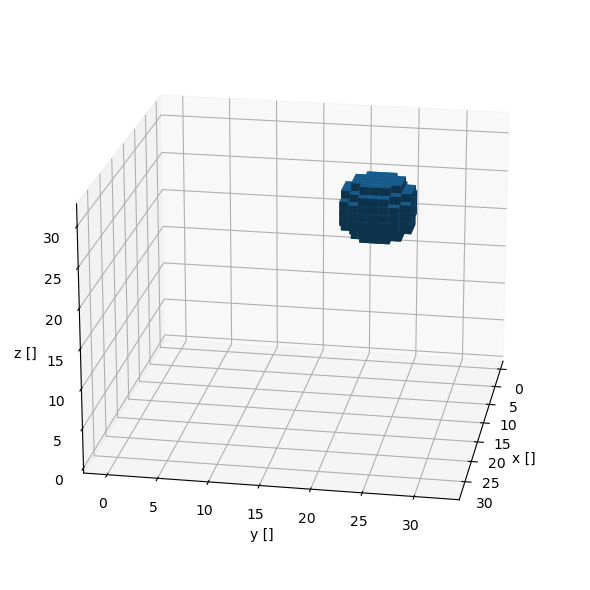

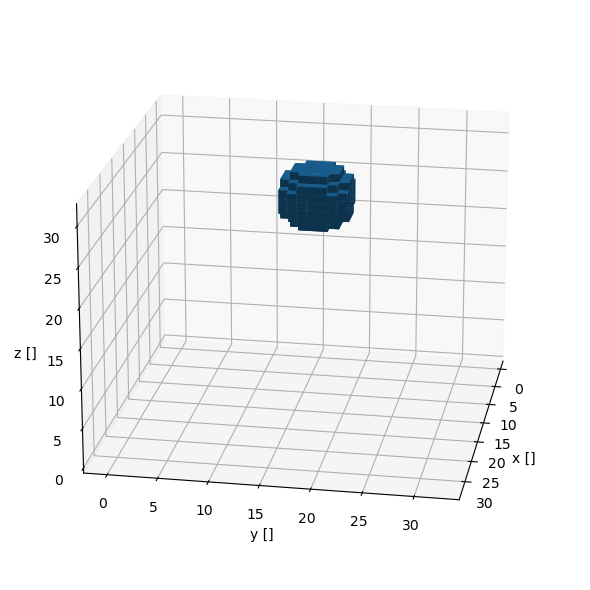

In [5]:
ns = 100
for idx in np.random.randint(0, ns, size=3):
    plot_voxel(gamma_train[idx, :, :, :, 0])

In [ ]:
vae = vae_model(input_shape=(32, 32, 32, 1), beta=1.05)
vae.compile(optimizer=Adam())
epoch_num = 450
batch_size = 100

history = vae.fit(gamma_train, epochs=epoch_num, batch_size=batch_size)
# callbacks = [LearningRateScheduler(learning_rate_scheduler)]

2023-12-29 19:50:36.208389: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-29 19:50:36.208449: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: 28f185d990a7
2023-12-29 19:50:36.208461: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: 28f185d990a7
2023-12-29 19:50:36.208645: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 470.141.3
2023-12-29 19:50:36.208685: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.141.3
2023-12-29 19:50:36.208701: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 470.141.3


Epoch 1/450
5/5 [==============================] - 6s 828ms/step - loss: 2229.7666 - reconstruction_loss: 1979.7687 - kl_loss: 0.0191
Epoch 2/450
5/5 [==============================] - 4s 813ms/step - loss: 1738.4480 - reconstruction_loss: 1749.4502 - kl_loss: 0.0279
Epoch 3/450
5/5 [==============================] - 4s 819ms/step - loss: 1680.6380 - reconstruction_loss: 1653.1875 - kl_loss: 0.0545
Epoch 4/450
5/5 [==============================] - 4s 820ms/step - loss: 1576.8264 - reconstruction_loss: 1571.9304 - kl_loss: 0.1993
Epoch 5/450
5/5 [==============================] - 4s 824ms/step - loss: 1540.4738 - reconstruction_loss: 1530.8032 - kl_loss: 1.4279
Epoch 6/450
5/5 [==============================] - 4s 851ms/step - loss: 1509.3866 - reconstruction_loss: 1500.0032 - kl_loss: 5.9785
Epoch 7/450
5/5 [==============================] - 4s 863ms/step - loss: 1488.0813 - reconstruction_loss: 1475.9899 - kl_loss: 10.1085
Epoch 8/450
5/5 [==============================] - 4s 856ms/s

In [ ]:
plot_loss_history(history)

plt.figure(figsize=(6, 4))
plt.title("Kl Loss History")
plt.plot(history.history["kl_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
if ball:
    gamma_test = gen_voxel_ball_data(num=100, d=d)
else:
    gamma_test = gen_voxel_brick_data(num=100, d_xyz=d_xyz)

In [ ]:
z_mean, z_log_var, z = vae.encoder.predict(gamma_test)
plot_latent_space_with_tsne(z_log_var)

In [ ]:
if ball:
    sgl_data = gen_voxel_ball_data(1, d=d)
else:
    sgl_data = gen_voxel_brick_data(1, d_xyz=d_xyz)
plot_voxel(sgl_data[0, :, :, :, 0], azim=0, elev=30)
z_mean, z_log_var, z = vae.encoder.predict(sgl_data)

In [ ]:
sgl_pred = vae.decoder.predict(z)
sgl_pred = np.squeeze(sgl_pred, axis=4)
sgl_pred = np.squeeze(sgl_pred, axis=0)
# sgl_pred = np.abs(np.round(sgl_pred))
sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)

plot_voxel(sgl_pred, azim=0, elev=30)

In [ ]:
plt.stem(np.concatenate(np.concatenate(sgl_pred)))

In [ ]:
vae.save_weights("models/vae_weights_beta.h5")
vae.save("models/vae_beta.keras")

## Load VAE